# Optimizations to MLP model


1. Magic numbers extracted
1. `@torch.no_grad()` decorator tells torch to not maintain backward graph

#### Init Loss

Fix Softmax being confidently wrong

Initialization: We want Uniform distribution for all the 27 characters (1/27)
Not confident incorrect answers
Init Loss = - (1.27).log() (Negative log likelihood)

Need Logits roughly 1
Hidden layer: W's random distribution

``` python
b2 = b2 * 0
W2 = W2 * 0.1 or 0.01
```
Can't do 0 in hidden layer, some low numbers / entropy. Helps to break symmetry

Removes Hockey stick appearance

We are spending less time squashing down the weights


#### Init TanH

Fix tanh layer too saturated at init

tanh is a squashing function which maps values from 

(-inf:inf) to (-1:1)

Gradient decreases as you go away from zero. If Outputs are extremes, then we aren't getting any training

Dead neuron: Neurons which never learn.

The tanh neuron will fire either -1 or 1. Similar issue for Sigmoid, Relu

Can happen on Init by high numbers or high learning rate.

Like a permanent brain damage 

LeakyRelu doesn't suffer from this

###### Solution:

We want hpreact to be closer to zero.

``` python
b1 = b1 * 0.01
W1 = W1 * 0.1

```

Deeper networks aren't that forgiving for such errors


#### Kaiming init

Preserve the gaussian init

``` python
x = randn 1000 x 10
w = randn 10 x 200 
w /= 5/3 * sqrt(fan_in)
y = x @ w

OR

torch.nn.init.kaiming_normal(
  tensor
  fan_in / fan_out
  nonlinearity: linear / relu / leakyRelu / tanh / etc
)
```

To have `y`'s std dev of 1, use `w = w / sqrt(fan_in)`

Modern innovations: 

- Residual corrections
- Norm layers: batch / layer / group
- Better Optimizers: not StochGradDescent, Armasprom, Adam

Makes less important for initialization

#### Batch Norm

Possible to train deep neural nets quite reliably

If you want `hpreact` (at init) to be roughly Gaussian, 
then, why not when you calc `hpreact` and turn that into Gaussian?

``` python
# BN gain and bias, at initialization
bngain = torch.ones((1,n_hidden))     # 1x200
bnbias = torch.zeros((1,n_hidden))    # 1x200

# Forward pass
hpreact = embcat @ W1 + b1            # 32x200
# 1. mini batch Mean
mean = hpreact.mean(0, keepdim=True)  # 1x200
# 2. mini batch Varianc e
std = hpreat.std(0, keepdim=True)     # 1x200
# 3. Normalize
hpreact = (hpreact - mean) / std
# 4. Scale and Shift
hpreact = bngain @ hpreact + bnbias

```

Batch Norm stabilizes the gain, but comes at a terrible cost.

Introduces padding, Jittering, entropy, Stabilizes training
2nd order effect that it behaves as a Regularizing layer
Works quite well, at controlling

bn gain & bias work on all the batch.

Alternatives: Layer, Instance, Group

Weird outcomes: 
 
Removed bias b1, useless as we have bnbias

1 step after training which calculates the Mean and Std for the entire training set, fixed numbers

If Norm, no bias needed

Calculate a running mean & dev jankily for inference.


#### ResNet 50

Image Classification

Image > ResNet

Seq set up blocks, repeated sequentially in series

Convolution: Linear layer on Patches. does it on overlapping patchies of input





#### Pytorchify

``` python

# Add classes for different Layers, Linear, BatchNorm1d, Tanh
# Defining layers
layers = [
  Layer(...)
]

```

Analysis Parameters

Distribution, Learning rate, Effects with Linear only, Linear + TanH, and L + Tan + BatchNorm


In [110]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


Magic numbers

In [111]:
from dataclasses import dataclass

@dataclass
class Config:
  specialToken = '.'
  blockSize = 3
  inputEmbedding = 10
  hiddenLayers = 200
  totalWords = 1356048
  seed = 2423425

config = Config()

In [112]:
# Import names: read from file '../names.txt'
words = open('../names.txt').read().splitlines()
len(words)

1356048

In [113]:
chars = [config.specialToken] + sorted(set(''.join(words)))
stoi = { c:i for (i,c) in enumerate(chars)}
itos = { i:c for (i,c) in enumerate(chars)}

Select Backend: CPU, MPS, CUDA

In [114]:
# device = torch.device("cpu")
device = torch.device("mps")
# device = torch.device("cuda")

device

device(type='mps')

Populate data into a Native matrix: X, Y

In [115]:
def build_dataset(words):
  block_size = config.blockSize
  specialToken = config.specialToken
  X, Y = [], []
  context = [stoi[config.specialToken]] * config.blockSize
  for w in words:
    for ch in w + specialToken:
      X.append(context)
      ix = stoi[ch]
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append
  X = torch.tensor(X, device=device)
  Y = torch.tensor(Y, device=device)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words=words[:n1])
Xdev, Ydev = build_dataset(words=words[n1:n2])
Xtest, Ytest = build_dataset(words=words[n2:])

# randomize names and set the training, dev and test set
    
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([7837977, 3]), torch.Size([980277, 3]), torch.Size([979965, 3]))

In [116]:
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([7837977, 3]), torch.Size([980277, 3]), torch.Size([979965, 3]))

In [117]:
lrs = 10**torch.linspace(-3,0,1000)

In [118]:
inChars = len(stoi)
intermediate = config.inputEmbedding * config.blockSize

def getFreshInputs():
  g = torch.Generator().manual_seed(config.seed)
  # prob for any char = 1/inChars
  uniform_prob = -torch.tensor(torch.tensor(1/inChars)).log() 
  # neg log prob: loss we expect
  C = torch.randn(inChars, config.inputEmbedding,generator=g).to(device)
  W1 = torch.randn(intermediate, config.hiddenLayers,generator=g).to(device)
  b1 = torch.randn(config.hiddenLayers, generator=g).to(device)
  W2 = torch.randn(config.hiddenLayers, len(stoi), generator=g).to(device)
  b2 = torch.randn(len(stoi), generator=g).to(device)
  parameters = [C, W1, b1, W2, b2]

  for p in parameters:
    p.requires_grad = True
  return parameters + [g]

C, W1, b1, W2, b2,  g = getFreshInputs()
lossi = []

In [119]:
def forward_and_backward(lr, parameters, batch_size=32) -> float:
  """Forward + Backward pass, return loss."""
  # unpack parameters
  C, W1, b1, W2, b2 = parameters
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  emb = C[Xtr[ix]]
  hpreact = (emb.view(emb.shape[0], -1) @ W1 + b1)
  h = hpreact.tanh()
  logits = (h @ W2 + b2)
  loss = F.cross_entropy(logits, Ytr[ix])
  #def backward():
  for p in parameters:
    p.grad = None
  loss.backward()
  for p in parameters:
    p.data += (-lr * p.grad)
  return loss.item()

In [120]:
@torch.no_grad
def getLoss(split):
  X,Y ={
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xtest, Ytest)
  }[split]
  emb = C[X]
  embcat = emb.view(emb.shape[0], -1)
  h = (emb @ W1 + b1).tanh()
  logits = (h @ W2 + b2)
  loss = F.cross_entropy(logits, Y)
  print(split, loss.item())
  return loss.item()

getLoss('dev')
getLoss('test')

In [ ]:
sp = stoi[config.specialToken]

@torch.no_grad
def sample(parameters):
  C, W1, b1, W2, b2, g = parameters
  context = [sp] * config.blockSize
  out = []
  while True:
    emb = C[torch.tensor(context, device=device)]
    h = (emb.view(1, -1) @ W1 + b1).tanh_()
    logits = (h @ W2 + b2)
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    out.append(ix)
    if ix == sp:
      break
  return ''.join([itos[ix] for ix in out])

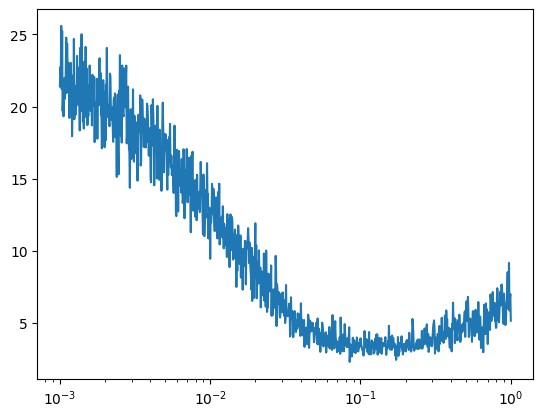

In [125]:
# Get optimal learning rate
for lr in lrs:
  l = forward_and_backward(lr, parameters=[C, W1, b1, W2, b2])
  lossi.append(l)

plt.plot(lrs, lossi)
plt.xscale('log')

min_lr = 0.1

In [126]:
C, W1, b1, W2, b2, g = getFreshInputs()
lossi = []

2.5506930351257324

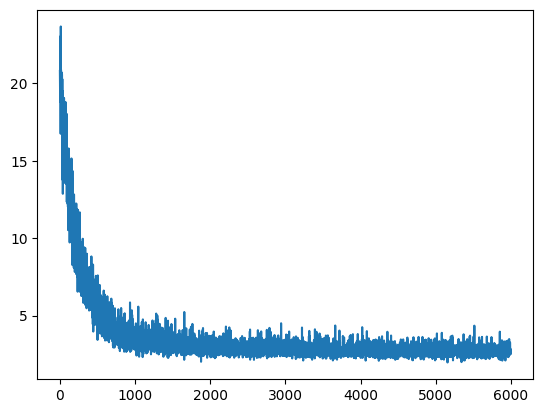

In [132]:
for i in range(1000):
  lossi.append(forward_and_backward(0.001, parameters=[C, W1, b1, W2, b2]))

plt.plot(lossi)
lossi[-1]